In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

DATA_PATH = '../bds/TSLA.csv'

# BOOSTING: DEFINIÇÕES E FORMALISMO MATEMÁTICO

### DEFINIÇÃO BOOSTING

Boosting é um método de aprendizado de máquina por agrupamento que combina um grupo de learns fracos a um learning forte. A ideia central do Boosting é ajustar cada novo modelo para os erros cometidos pelos modelos anteriores, com o objetivo de melhorar a performance geral.




### DEFINIÇÃO: LEARNING FRACO

Um modelo fraco é um estimador que, por exemplo, pode ser uma árvore de decisão com uma profundidade pequena ou um modelo linear simples. A ideia é que, apesar de cada modelo fraco não ser muito preciso, eles têm uma tendência a ser melhores do que o acaso. Quando combinados de forma adequada, podem formar um modelo robusto e poderoso.

O objetivo geral do boosting é melhorar o desempenho preditivo de modelos de aprendizado de máquina ao combinar múltiplos modelos fracos (ou seja, modelos com desempenho apenas um pouco melhor que o acaso) para criar um modelo mais forte e preciso. Esse processo é realizado através da combinação sequencial de modelos, onde cada novo modelo corrige os erros dos modelos anteriores.

O boosting é importante porque melhora a precisão dos modelos ao combinar múltiplos modelos fracos em um modelo forte e eficaz. Ele ajusta o peso das observações difíceis de prever, resultando em um desempenho superior. Adaptável a diferentes tipos de problemas, o boosting também pode ser menos suscetível ao overfitting com a regulação adequada. 

<center><img src='../images/framework_boosting.png' width='500' /></center>

<center><img src='../images/Generic-boosting-framework.png' width='500' /></center>

### FORMALISMO MATEMÁTICO

Seja $\{(x_i,y_i)\}_{i=0}^n$, talque $x_i$ são nossos features e $y_i$ o nosso target. Um modelo fraco pode ser representado por $h_i(x)$, onde $i$ varia de 1 até a quantidade de modelos fracos usados, e o nosso Boosting como um modelo composto $F(x)$ a partir de uma combinação de modelos fracos. Cada modelo fraco terá o seu valor de contribuição para a previsão, de qual forma que para cada m de 1 até a quantidade de modelos fracos vamos ter o seu nível de contribuição como $\alpha_m$.

#### Construindo um Modelo Forte através de Modelos Fracos (Boosting)

1. **Treinamento do Primeiro Modelo Fraco:**
   - Treine o primeiro modelo fraco $h_1(x)$ para ajustar os dados de treinamento.
   - Calcule o erro residual inicial $e_1$, onde:
     $$
     e_1 = y - h_1(x)
     $$

2. **Treinamento do Segundo Modelo Fraco:**
   - O segundo modelo fraco $h_2(x)$ é treinado para prever o erro residual $e_1$.
   - Atualize a previsão acumulada:
     $$
     F_2(x) = h_1(x) + \alpha_2 h_2(x)
     $$
     onde $\alpha_2$ é o parâmetro de ajuste para o segundo modelo.

3. **Atualização do Erro Residual:**
   - Calcule o novo erro residual $e_2$ como:
     $$
     e_2 = y - F_2(x)
     $$

4. **Repetição do Processo:**
   - Para iterações subsequentes $m \in \{3, \dots, M\}$, o processo é repetido:
     - Treine o modelo fraco $h_m(x)$ para prever o erro residual $e_{m-1}$.
     - Atualize a previsão acumulada:
       $$
       F_m(x) = F_{m-1}(x) + \alpha_m h_m(x)
       $$
     - Calcule o novo erro residual $e_m$:
       $$
       e_m = y - F_m(x)
       $$


O processo de Boosting continua até que um critério de parada seja atendido. Os critérios comuns incluem:

Número Máximo de Iterações: O algoritmo para quando o número máximo de modelos fracos é alcançado.

Desempenho do Modelo: O algoritmo pode parar quando as melhorias no erro residual tornam-se pequenas, ou quando o erro de validação não melhora significativamente (Early Stopping).

Após isso, temos como equação da nossa previsão via Boosting:
#### Equação da Previsão via Boosting

No algoritmo de Boosting, a previsão final do modelo é dada por:

$$
F_M(x) = F_0(x) + \sum_{m=1}^{M} \alpha_m h_m(x)
$$

onde:

- $F_M(x)$ é a previsão final após $M$ iterações.
- $F_0(x)$ é a previsão inicial do modelo.
- $\alpha_m$ é o parâmetro de ajuste para o modelo fraco $h_m(x)$.
- $h_m(x)$ é o modelo fraco treinado na $m$-ésima iteração.




#### Cálculo do Parâmetro de Ajuste $\alpha_m$ em Boosting

No algoritmo de Boosting, a contribuição de cada modelo fraco $h_m(x)$ é ajustada pelo parâmetro $\alpha_m$. O cálculo de $\alpha_m$ visa minimizar a função de perda ao adicionar o modelo fraco ao modelo atual.

##### Cálculo de $\alpha_m$

Para calcular $\alpha_m$, utilizamos a função de perda $L$ para encontrar o valor que minimiza o erro ao adicionar o modelo fraco $h_m(x)$ ao modelo atual $F_{m-1}(x)$. 

1. **Erro Residual:** O erro residual para a iteração $m$ é dado por:

   $$
   r_{i,m-1} = y_i - F_{m-1}(x_i)
   $$

2. **Função de Perda:** A função de perda $L_{m}$ que queremos minimizar é:

   $$
   L_{m} = \sum_{i=1}^{n} L\left(y_i, F_{m-1}(x_i) + \alpha_m h_m(x_i)\right)
   $$

3. **Cálculo de $\alpha_m$:** Para encontrar $\alpha_m$, derivamos $L_{m}$ em relação a $\alpha_m$ e igualamos a zero:

   $$
   \frac{\partial L_{m}}{\partial \alpha_m} = -2 \sum_{i=1}^{n} (y_i - (F_{m-1}(x_i) + \alpha_m h_m(x_i))) h_m(x_i) = 0
   $$

   Simplificando, obtemos:

   $$
   \alpha_m = \frac{\sum_{i=1}^{n} (y_i - F_{m-1}(x_i)) h_m(x_i)}{\sum_{i=1}^{n} (h_m(x_i))^2}
   $$

Aqui, $\alpha_m$ representa a contribuição do modelo fraco $h_m(x)$ na atualização do modelo.



### EXEMPLOS DE BOOSTING POPULARES

* Adaboost
* Gradient Boosting
* XGBoost
* LightGBM
* CatBoost


##### 1. XGBoost (Extreme Gradient Boosting)
- **Descrição:** Um dos algoritmos mais populares devido à sua robustez e flexibilidade. Ele utiliza Gradient Boosting e é altamente eficiente para problemas de regressão.
- **Vantagens:**
  - Capacidade de regularização (L1 e L2), ajudando a evitar overfitting.
  - Suporte para múltiplas funções de perda, como MSE (Mean Squared Error) e MAE (Mean Absolute Error).
  - Facilidade no ajuste de hiperparâmetros para melhorar a precisão das previsões.
- **Aplicações de Regressão:** Previsão de preços, séries temporais, previsões financeiras.

##### 2. LightGBM (Light Gradient Boosting Machine)
- **Descrição:** Altamente eficiente em termos de tempo e uso de memória, especialmente em datasets grandes. Também se baseia em Gradient Boosting.
- **Vantagens:**
  - Suporte para uma ampla gama de funções de perda usadas em regressão, como Huber loss, robusta contra outliers.
  - Algoritmo otimizado para performance em grandes conjuntos de dados.
  - Construção de árvores de decisão mais profundas, capturando interações complexas entre as variáveis.
- **Aplicações de Regressão:** Modelos de previsão para grandes datasets, modelagem de risco financeiro, previsão de demanda.

##### 3. CatBoost (Categorical Boosting)
- **Descrição:** Além de ser eficiente com variáveis categóricas, o CatBoost também é eficaz em tarefas de regressão, oferecendo alta precisão e facilidade de uso.
- **Vantagens:**
  - Funciona bem sem a necessidade de muito ajuste de hiperparâmetros.
  - Oferece suporte a funções de perda robustas para regressão, como quantile loss para intervalos de confiança.
  - Reduz significativamente o risco de overfitting.
- **Aplicações de Regressão:** Previsão de vendas, modelagem de séries temporais, avaliação de propriedades.

##### 4. Gradient Boosting (Scikit-learn)
- **Descrição:** Implementação mais tradicional do Gradient Boosting, disponível no Scikit-learn. Embora não seja tão rápido quanto XGBoost ou LightGBM, é muito usado em tarefas de regressão devido à sua simplicidade e robustez.
- **Vantagens:**
  - Fácil de implementar e interpretar.
  - Suporte para várias funções de perda para regressão, como MSE e MAE.
  - Integrado diretamente ao ecossistema Scikit-learn.
- **Aplicações de Regressão:** Tarefas de previsão onde a simplicidade e a interpretabilidade são importantes.

##### 5. AdaBoost (Adaptive Boosting)
- **Descrição:** AdaBoost é um dos primeiros algoritmos de Boosting e é conhecido por ajustar iterativamente modelos fracos, como stumps de decisão, e combiná-los para formar um modelo forte.
- **Vantagens:**
  - Simplicidade e eficácia em melhorar a performance de modelos fracos.
  - Versatilidade para ser usado com várias funções de perda para regressão.
  - Bom desempenho em problemas de regressão quando combinado com modelos fracos como regressão linear simples ou stumps.
- **Aplicações de Regressão:** Previsão de séries temporais simples, ajuste de modelos de baixa complexidade.


# BOOSTING: EXEMPLOS PRÁTICOS

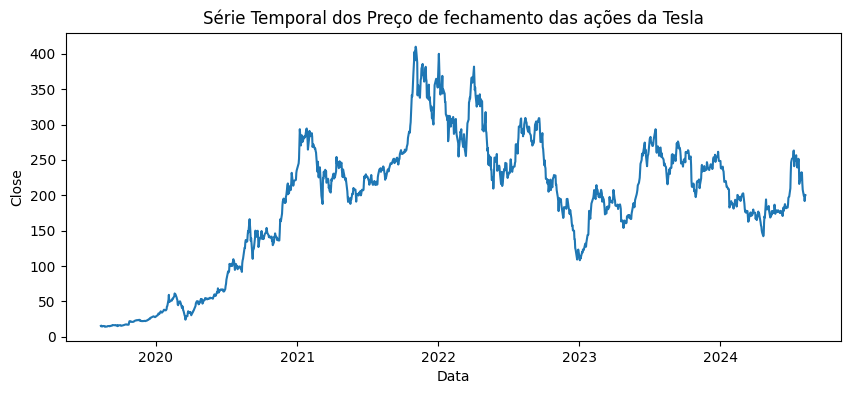

In [2]:
# LENDO O CONJUNTO DE DADOS
bd_tesla = pd.read_csv(DATA_PATH, sep=',')
# GERANDO A SÉRIE TEMPORAL, INDEXADA PELA DATE E O NOSSO TARGET COMO SENDO O CLOSE
TM_tesla = bd_tesla[['Date','Close']]
TM_tesla.loc[:,'Date'] = pd.to_datetime(TM_tesla['Date'])
# PLOTANDO A SÉRIE TEMPORAL
plt.figure(figsize=(10, 4))
plt.plot(TM_tesla['Date'], TM_tesla['Close']) 
plt.title(f'Série Temporal dos Preço de fechamento das ações da Tesla')
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()


## EXEMPLO DE BOOSTING 


Inicialmente, faremos o estudo dos lags e pegaremos eles no nosso conjunto de dados, para serem usados como features nos nossos modelos de Boosting.

significantLags: [1, 8, 10, 19, 25]


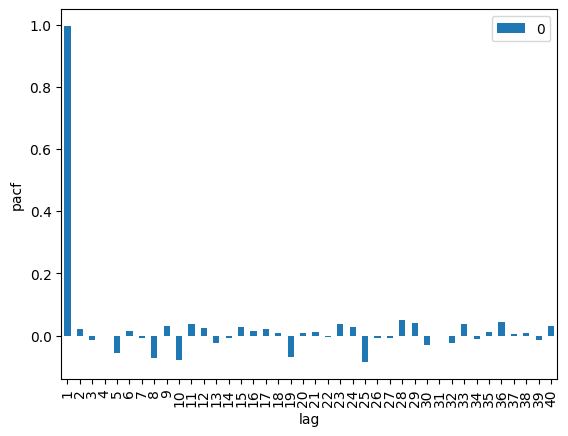

In [3]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags
e1_significantLags = getSignificantLags(y=TM_tesla['Close'], nLags = 40, alpha=0.05)

In [4]:
def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df
TM_tesla = appendLagVariables(yNm='Close', 
                         significantLags = e1_significantLags, 
                         df = TM_tesla, 
                         dropna=True)

,Date,Close,(Close-1),(Close-8),(Close-10),(Close-19),(Close-25)
25,2019-09-17 00:00:00,16.319332,16.187332,15.305333,15.000667,15.057333,15.267333
26,2019-09-18 00:00:00,16.232668,16.319332,15.163333,14.712000,14.722000,15.666667


In [5]:

df = TM_tesla.dropna()

# Separar features e target
X = df.drop('Close', axis=1)
X = X.drop('Date', axis=1)
y = df['Close']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## XGBOOST REGRESSOR

O XGBoost (Extreme Gradient Boosting) é um algoritmo de aprendizado de máquina baseado em árvores de decisão, projetado para ser altamente eficiente, flexível e portátil. Ele é amplamente utilizado para problemas de classificação e regressão

O XGBoost Regressor constrói uma série de árvores de decisão de forma sequencial, onde cada nova árvore tenta corrigir os erros cometidos pelas árvores anteriores. O objetivo é minimizar uma função de perda, como o erro quadrático médio (MSE), de forma que a soma das predições das árvores resulte em previsões mais precisas.

O XGBoost Regressor utiliza uma abordagem de Boosting de Gradiente para construir um ensemble de árvores de decisão, minimizando uma função objetivo que combina a função de perda com termos de regularização para controlar a complexidade do modelo. A abordagem matemática envolve a otimização sequencial com gradientes de primeira e segunda ordem, resultando em um modelo robusto e eficiente para tarefas de regressão.

- **`objective='reg:squarederror'`**: Define a função de perda como erro quadrático médio (MSE) para regressão.
- **`learning_rate=0.028`**: Controla o tamanho dos passos ao ajustar os pesos; learning rate menor permite ajustes mais graduais.
- **`n_estimators=120`**: Número de árvores que serão treinadas.
- **`subsample=0.8`**: Fração dos dados de treinamento usados para construir cada árvore (80%).
- **`colsample_bytree=0.8`**: Fração das features usadas para treinar cada árvore (80%).

In [6]:
# Treinar o modelo XGBoost
model = XGBRegressor(objective='reg:squarederror',learning_rate=0.028,n_estimators=120,subsample=0.8, colsample_bytree=0.8)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 68.01751544739562


Um Mean Squared Error (MSE) de 68.01 indica que, em média, o quadrado da diferença entre os valores reais e os valores previstos pelo modelo é 68.01. 

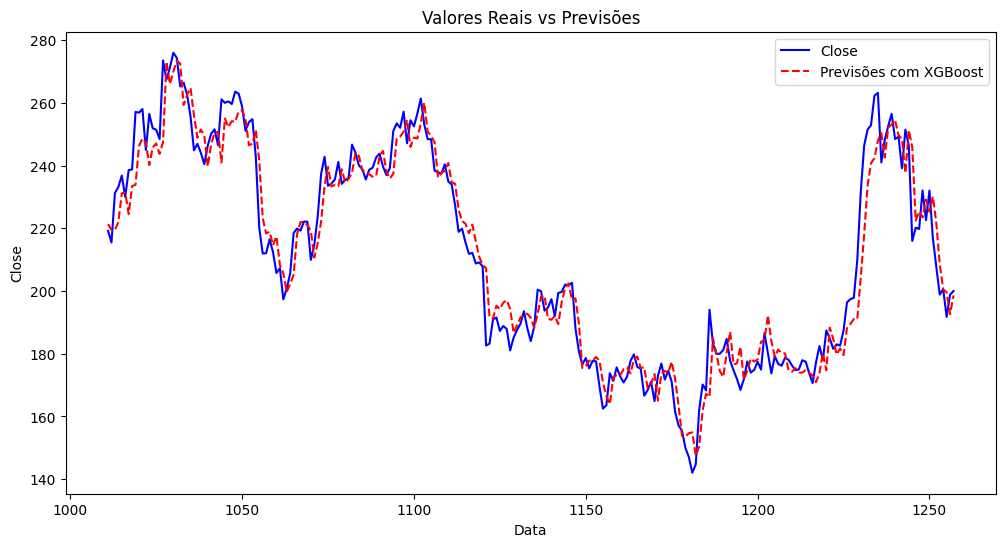

In [7]:
results = pd.DataFrame({'Real': y_test, 'Previsão': y_pred}, index=y_test.index)
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Real'], label='Close', color='blue')
plt.plot(results.index, results['Previsão'], label='Previsões com XGBoost', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Close')
plt.title('Valores Reais vs Previsões')
plt.legend()
plt.show()

Os últimos dois dias são 08/08/24 e 09/08/2024, que são quinta-feira e sexta-feira respectivamente, com esses dados queremos prever os dados para os dias 12/08/2024 e 13/08/2024.

Para o dia 12 de ago. de 2024 temos o valor de fechamento de 197,49	enquanto que para o dia 13 de ago. de 2024 o valor de fechamento das ações foram de 207,83. Essa fonte é baseaod nos dados mais atualizados da plataforma Yahoo Finaças.

Vamos organizar os dados agora para fazermos a previsão para esses dias e comparar os resultados previstos para os originais.

In [8]:
TM_tesla.tail(3)

,Date,Close,(Close-1),(Close-8),(Close-10),(Close-19),(Close-25)
1255,2024-08-07 00:00:00,191.759995,200.639999,219.800003,215.990005,241.029999,231.259995
1256,2024-08-08 00:00:00,198.839996,191.759995,232.100006,220.250000,248.229996,246.389999
1257,2024-08-09 00:00:00,200.000000,198.839996,222.619995,219.800003,252.639999,251.520004


In [9]:
# Obtenha os lags do dia 1257
ultimos_lags = X_test.iloc[-1]  # Últimos lags (correspondentes a t-1, t-8, t-10, t-19, t-25)

# Prever para o dia 1258
previsao_1258 = model.predict(ultimos_lags.values.reshape(1, -1))

# Extraia o valor escalar da previsão
previsao_1258_valor = previsao_1258[0]

# Atualize os lags para o dia 1258
novos_lags_1258 = np.roll(ultimos_lags.values, 1)
novos_lags_1258[0] = previsao_1258_valor  # Atualiza o lag `t-1` com a previsão para 1258

# Obtenha os lags para o dia 1259
ultimos_lags_1258 = pd.Series(novos_lags_1258, index=ultimos_lags.index)

# Prever para o dia 1259
previsao_1259 = model.predict(ultimos_lags_1258.values.reshape(1, -1))

# Extraia o valor escalar da previsão
previsao_1259_valor = previsao_1259[0]

# Imprimir as previsões
print(f"Previsão para o dia 12/08: {previsao_1258_valor} | Valor Real: 197,49")
print(f"Previsão para o dia 13/08: {previsao_1259_valor} | Valor Real: 207,83")

Previsão para o dia 12/08: 198.5974884033203 | Valor Real: 197,49
Previsão para o dia 13/08: 194.61898803710938 | Valor Real: 207,83


## ADABOOST

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

In [11]:
# Criando o modelo de regressão linear como learner fraco
base_learner = LinearRegression()
# Criando o modelo AdaBoost com o learner fraco
ada_model = AdaBoostRegressor(estimator=base_learner, n_estimators=140, learning_rate=0.02, random_state=42)


In [12]:
# Treinando o modelo
ada_model.fit(X_train, y_train)
# Fazendo previsões
y_pred = ada_model.predict(X_test)
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 51.97


Um Mean Squared Error (MSE) de 51.97 indica que, em média, o quadrado da diferença entre os valores reais e os valores previstos pelo modelo é 51.97. 

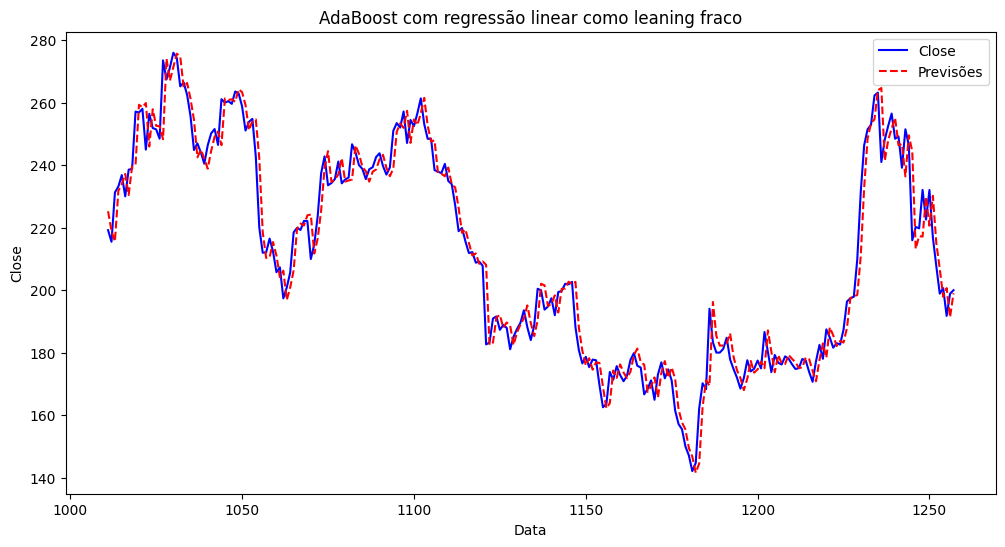

In [13]:
results = pd.DataFrame({'Real': y_test, 'Previsão': y_pred}, index=y_test.index)
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Real'], label='Close', color='blue')
plt.plot(results.index, results['Previsão'], label='Previsões', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Close')
plt.title('AdaBoost com regressão linear como leaning fraco')
plt.legend()
plt.show()

Os últimos dois dias são 08/08/24 e 09/08/2024, que são quinta-feira e sexta-feira respectivamente, com esses dados queremos prever os dados para os dias 12/08/2024 e 13/08/2024.

Para o dia 12 de ago. de 2024 temos o valor de fechamento de 197,49	enquanto que para o dia 13 de ago. de 2024 o valor de fechamento das ações foram de 207,83. Essa fonte é baseaod nos dados mais atualizados da plataforma Yahoo Finaças.

Vamos organizar os dados agora para fazermos a previsão para esses dias e comparar os resultados previstos para os originais.

In [14]:
# Obtenha os lags do dia 1257
ultimos_lags = X_test.iloc[-1]  # Últimos lags (correspondentes a t-1, t-8, t-10, t-19, t-25)

# Prever para o dia 1258
previsao_1258 = ada_model.predict(ultimos_lags.values.reshape(1, -1))

# Extraia o valor escalar da previsão
previsao_1258_valor = previsao_1258[0]

# Atualize os lags para o dia 1258
novos_lags_1258 = np.roll(ultimos_lags.values, 1)
novos_lags_1258[0] = previsao_1258_valor  # Atualiza o lag `t-1` com a previsão para 1258

# Obtenha os lags para o dia 1259
ultimos_lags_1258 = pd.Series(novos_lags_1258, index=ultimos_lags.index)

# Prever para o dia 1259
previsao_1259 = ada_model.predict(ultimos_lags_1258.values.reshape(1, -1))

# Extraia o valor escalar da previsão
previsao_1259_valor = previsao_1259[0]

# Imprimir as previsões
print(f"Previsão para o dia 12/08: {previsao_1258_valor} | Valor Real: 197,49")
print(f"Previsão para o dia 13/08: {previsao_1259_valor} | Valor Real: 207,83")

Previsão para o dia 12/08: 199.0215131336644 | Valor Real: 197,49
Previsão para o dia 13/08: 199.85795045712365 | Valor Real: 207,83


c:\Users\allan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
c:\Users\allan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


## HIBRIDISMO


Hibridismo em Boosting combina modelos complementares para melhorar o desempenho da previsão, explorando suas forças individuais. Em séries temporais, essa abordagem pode envolver integrar modelos tradicionais, como ARIMA, com técnicas de Boosting, como XGBoost, para capturar tanto padrões lineares quanto não-lineares. Por exemplo, pode-se usar ARIMA para modelar a tendência e sazonalidade dos dados, e aplicar XGBoost para capturar os resíduos não explicados, aprimorando a precisão da previsão. Essa combinação é eficaz em cenários onde um único modelo não consegue capturar todas as dinâmicas dos dados.

Exemplo: Prever o preço de ações com ARIMA + XGBoost: o ARIMA modela a tendência e a sazonalidade, e o XGBoost refina a previsão considerando os resíduos restantes.

Benefícios do Hibridismo:

- Melhoria na Precisão: Combinar modelos pode melhorar a precisão da previsão, pois diferentes modelos capturam diferentes aspectos dos dados.
- Robustez: A hibridização pode tornar o modelo mais robusto a diferentes tipos de variabilidade nos dados.
- Flexibilidade: Permite a combinação de modelos que são bons em diferentes aspectos, como tendências, sazonalidades e padrões complexos.

In [19]:
from sklearn.ensemble import StackingRegressor

In [22]:
# Configurando o Stacking com Regressão Linear e XGBoost
linear_model = LinearRegression()
xgb_model = XGBRegressor()
stacking_model = StackingRegressor(
    estimators=[('linear', linear_model), ('xgb', xgb_model)],
    final_estimator=LinearRegression()
)

MSE Final: 52.6133


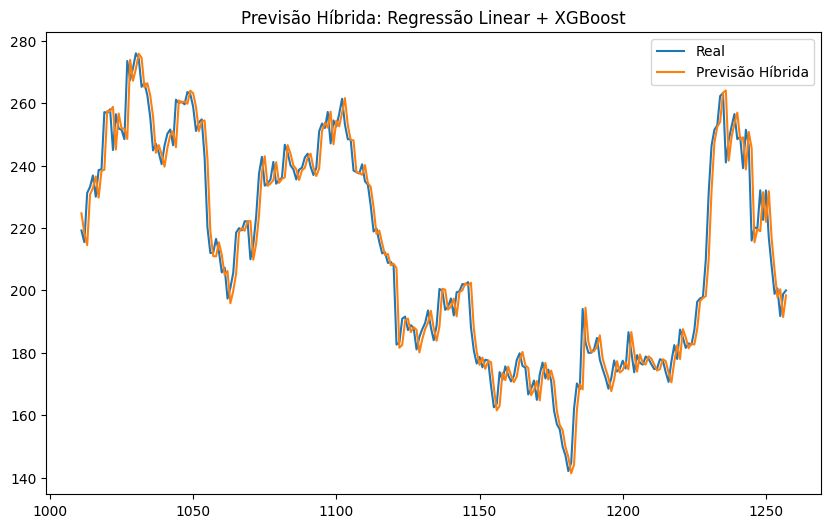

In [23]:
# Treinando o modelo de hibridismo
stacking_model.fit(X_train, y_train)
# Fazendo previsões
y_pred = stacking_model.predict(X_test)
# Avaliando o desempenho
mse = mean_squared_error(y_test, y_pred)
print(f'MSE Final: {mse:.4f}')
# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Previsão Híbrida')
plt.title('Previsão Híbrida: Regressão Linear + XGBoost')
plt.legend()
plt.show()

Os últimos dois dias são 08/08/24 e 09/08/2024, que são quinta-feira e sexta-feira respectivamente, com esses dados queremos prever os dados para os dias 12/08/2024 e 13/08/2024.

Para o dia 12 de ago. de 2024 temos o valor de fechamento de 197,49	enquanto que para o dia 13 de ago. de 2024 o valor de fechamento das ações foram de 207,83. Essa fonte é baseaod nos dados mais atualizados da plataforma Yahoo Finaças.

Vamos organizar os dados agora para fazermos a previsão para esses dias e comparar os resultados previstos para os originais.

In [24]:
# Obtenha os lags do dia 1257
ultimos_lags = X_test.iloc[-1]  # Últimos lags (correspondentes a t-1, t-8, t-10, t-19, t-25)

# Prever para o dia 1258
previsao_1258 = stacking_model.predict(ultimos_lags.values.reshape(1, -1))

# Extraia o valor escalar da previsão
previsao_1258_valor = previsao_1258[0]

# Atualize os lags para o dia 1258
novos_lags_1258 = np.roll(ultimos_lags.values, 1)
novos_lags_1258[0] = previsao_1258_valor  # Atualiza o lag `t-1` com a previsão para 1258

# Obtenha os lags para o dia 1259
ultimos_lags_1258 = pd.Series(novos_lags_1258, index=ultimos_lags.index)

# Prever para o dia 1259
previsao_1259 = stacking_model.predict(ultimos_lags_1258.values.reshape(1, -1))

# Extraia o valor escalar da previsão
previsao_1259_valor = previsao_1259[0]

# Imprimir as previsões
print(f"Previsão para o dia 12/08: {previsao_1258_valor} | Valor Real: 197,49")
print(f"Previsão para o dia 13/08: {previsao_1259_valor} | Valor Real: 207,83")

Previsão para o dia 12/08: 198.4085132621587 | Valor Real: 197,49
Previsão para o dia 13/08: 197.5541935866785 | Valor Real: 207,83


c:\Users\allan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\allan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
